## Variation in Nitrogen Wet Deposition with Precipitation Intensity and Frequency in New Hampshire

@author = Paola Miramontes
@date = 2025-10-20
@license = MIT -- https://opensource.org/licenses/MIT

## INTRODUCTION
Nitrogen (N) deposition is essential to nutrient cycling and transport between atmospheric, terrestrial, and aquatic ecosystems.
Studying N wet deposition is particularly important because it directly influences water quality, soil processes, and ecosystem 
productivity. The amount and type of N deposited can be influenced by multiple factors, including seasonal patterns, emission 
sources, and atmospheric transport (Murray & Wymore, 2024; Nanus et al., 2018; Wetherbee & Mast, 2016).

With ongoing changes in climate, shifts in precipitation frequency and intensity could alter N deposition patterns, potentially affecting nutrient loading and ecosystem dynamics. Understanding these relationships and identifying the key drivers of nitrogen wet deposition across temporal and spatial scales will help refine management strategies aimed at mitigating the harmful effects of excess or limited N deposition to terrestrial and aquatic ecosystems.

## Research question and hypothesis
### Research question: 
How does nitrogen wet deposition vary with changes in precipitation intensity and frequency in New Hampshire?

### Hypothesis: 
Nitrogen wet deposition increases with higher precipitation intensity and frequency, because more intense or frequent storms enhance scavenging of atmospheric nitrogen compounds.

## Study site description
![NH_WetDepCollectors](TF_HB_Map.jpg)
Figure 1. Map of location of wet deposition collectors in Hubbard Brook watershed and Thompson Farm (within Lampre River watershed). Maps modified from Wymore et al. 2021 and https://hubbardbrook.org/online-book-chapter/the-hubbard-brook-ecosystem-study-site-history-and-research-approaches/

## Data Description
Weekly Hubbard Brook wet deposition data from the National Atmospheric Deposition Program (NADP) from 1978-2025.
Thompson Farm weekly wet deposition chemistry from 2003-2025. Daily precipation quantity from Climate Reference Network.


## RESULTS

## Precipitation Data
This code imports, cleans, and combines weekly precipitation data for Thompson Farm (TF) using Climate Reference Network (CRN) data and Hubbard Brook (HB). Daily CRN precipitaion totals are calculated based on TF weekly sample interval collection. It then plots a time series showing total weekly precipitation(mm) for both sites.

In [1]:
#%% Import libraries
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import linregress
import os
from pathlib import Path
import matplotlib.dates as mdates
import calendar

In [2]:
#%% Parameters
TF_file='20241022 Lamprey Precipitation Query w formatting_M.S.csv'
HB_file='NTN-nh02-w-s-mg.csv'

# Subdirectory to data folder
cd = Path(os.getcwd())
data = cd / 'data'

TF_file = data / '20241022_Lamprey_Precipitation.csv'
CRN_file = data / '20031001 to 20210422 CRN Data UNHIDs Filled.csv'
HB_file   = data / 'NTN-nh02-w-s-mg.csv'

In [3]:
#%%Load data
TF_df = pd.read_csv(TF_file)
CRN = pd.read_csv(CRN_file)
HB_df = pd.read_csv(HB_file)

#%%Thompson Farm (TF) data
#Keep only TF data (Includes deposition data throughout the Lamprey River Hydrological Observatory)
TF_df = TF_df[TF_df['Sample Name'] == 'TF2']

TF_df=TF_df.rename(columns={'Sample Name': 'site'})

#Make a sub dataframe
TF_sub = TF_df[['Collection Date', 'site']].copy()
TF_sub['Date'] = pd.to_datetime(TF_sub['Collection Date'], format='%d-%b-%y')

# Create sampling intervals
TF_sub = TF_sub.sort_values('Date').reset_index(drop=True)
TF_sub['EndDate'] = TF_sub['Date']
TF_sub['StartDate'] = TF_sub['Date'].shift(1)
TF_sub['yrmonth'] = TF_sub['EndDate'].dt.year * 100 + TF_sub['EndDate'].dt.month
TF_sub['yrmonth'] = TF_sub['yrmonth'].astype(int)
TF_sub['Sampling.Interval'] = range(1, len(TF_sub) + 1)

#%% CRN precipitation data for TF
CRN['Date_new'] = pd.to_datetime(CRN['Date_Hour_end_EST'], format='%m/%d/%y %H:%M')

#Assign sampling intervals
for _, row in TF_sub.iterrows():
    mask = (CRN['Date_new'] > row['StartDate']) & (CRN['Date_new'] <= row['EndDate'])
    CRN.loc[mask, 'Sampling.Interval'] = row['Sampling.Interval']

#Sum CRN precipitation per interval
CRN_sum = (
    CRN.groupby('Sampling.Interval', dropna=False)
    .agg(CRN_Sum_mm=('TF_P_wUNHfilled_mm', 'sum'))
    .reset_index())

# Merge with TF
precip_TF = TF_sub.merge(CRN_sum, on='Sampling.Interval', how='left')
precip_TF['precip_mm'] = precip_TF['CRN_Sum_mm']
precip_TF = precip_TF[['StartDate', 'EndDate', 'site', 'precip_mm','yrmonth']].copy()

/var/folders/gx/xb0346x15szdrg791tjf03q40000gn/T/ipykernel_64783/296444337.py:3: DtypeWarning: Columns (0,15,18,21,22,27,28,30,31,34,35,36,37,38,40,42,44,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76) have mixed types. Specify dtype option on import or set low_memory=False.
  CRN = pd.read_csv(CRN_file)


In [4]:
#%%Hubbard Brook (HB) data
HB_df = HB_df.rename(
    columns={
        'dateOn': 'StartDate',
        'dateOff': 'EndDate',
        'siteID': 'site',
        'subppt': 'precip_mm'
    }
).replace(-9, np.nan)

#Remove replace all negative precipitation values
HB_df.loc[HB_df['precip_mm'] < 0, 'precip_mm'] = np.nan

# Keep only key columns
HB_sub = HB_df[['StartDate', 'EndDate', 'site', 'precip_mm', 'yrmonth']].copy()

In [5]:
#%%Combine datasets to get a complete precipitation df

#Concatenate datasets
df_precip = pd.concat([precip_TF, HB_sub], ignore_index=True)
df_precip['site'] = df_precip['site'].replace({'NH02': 'HB', 'TF2': 'TF'})

#Clean up missing values
df_precip_clean = df_precip.dropna(subset=['StartDate', 'EndDate', 'precip_mm']).copy()
#Ensure StartDate and EndDate are datetime
df_precip_clean['StartDate'] = pd.to_datetime(df_precip_clean['StartDate'], errors='coerce')
df_precip_clean['EndDate']   = pd.to_datetime(df_precip_clean['EndDate'], errors='coerce')

##Determine water year
df_precip_clean['WaterYear'] = df_precip_clean['EndDate'].dt.year
df_precip_clean.loc[df_precip_clean['EndDate'].dt.month >= 10, 'WaterYear'] += 1

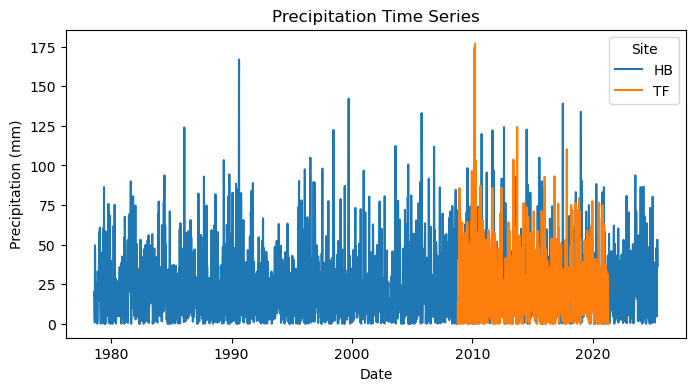

In [6]:
#%%Timeseries Plot
fig, ax = plt.subplots(figsize=(8, 4))

for site in ['HB', 'TF']:
    if site in df_precip_clean['site'].unique():
        site_data = df_precip_clean[df_precip_clean['site'] == site]
        ax.plot(site_data['EndDate'], site_data['precip_mm'], label=site)

ax.set(
    xlabel='Date',
    ylabel='Precipitation (mm)',
    title='Precipitation Time Series'
)
ax.legend(title='Site')
plt.show()

### Long-Term Trends in Precipitation
Comparing long-term precipitation trends at both sites to determine whether total precipitation per year has changed over time or if number of high-precipitation events changed over time.

Precipitation frequency: number of weeks per year with measurable precipitation? (Deciding if this is relevant)

High-intensity precipitation: number of events above a certain threshold (e.g. 95th percentile of all events).

Linear regression of precipitation frequency over time (e.g. Figure 5 in Howarth et al., 2019) or 
Bar graphs of precipitation frequency for multiple high precipitation events (e.g. Figure 6 in Howarth et. al., 2019)

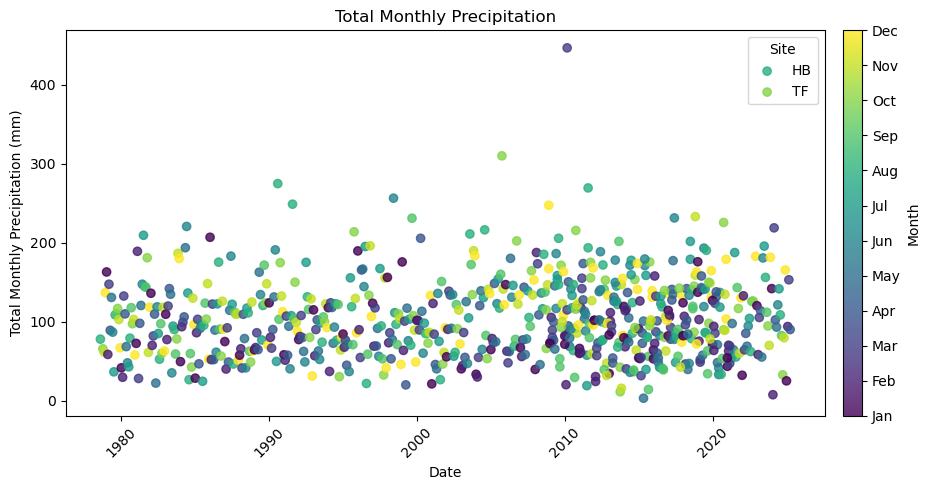

In [7]:
#%%Monthly precipitation totals and max

# Aggregate total monthly precipitation per site
monthly_precip = (
    df_precip_clean.groupby(['site', 'yrmonth'])
    .agg(
        total_precip_mm=('precip_mm', 'sum'),
        max_precip_mm=('precip_mm', 'max'),
        n_events=('precip_mm', 'count')
    )
    .reset_index()
)

# Create a datetime column for plotting
monthly_precip['Date'] = pd.to_datetime(monthly_precip['yrmonth'].astype(str), format='%Y%m')

#Filter out incomplete months
monthly_precip = monthly_precip[monthly_precip['n_events'] >= 4]

#%%Total monthly precipitation points color coded by month

# Extract month number and name for coloring
monthly_precip['month'] = monthly_precip['Date'].dt.month
monthly_precip['month_name'] = monthly_precip['Date'].dt.month_name()

# Plot: color by month (same colormap across both sites)
fig, ax = plt.subplots(figsize=(10,5))

for site in monthly_precip['site'].unique():
    site_data = monthly_precip[monthly_precip['site'] == site]
    sc = ax.scatter(
        site_data['Date'],
        site_data['total_precip_mm'],
        c=site_data['month'],
        cmap='viridis',
        label=site,
        alpha=0.8
    )

ax.set_xlabel('Date')
ax.set_ylabel('Total Monthly Precipitation (mm)')
ax.set_title('Total Monthly Precipitation')
ax.legend(title='Site')

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, pad=0.02)
cbar.set_label('Month')
cbar.set_ticks(range(1,13))
cbar.set_ticklabels(calendar.month_abbr[1:])

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Trends in precipitation intensity and frequency
Determine if number of high-precipitation events changed over time

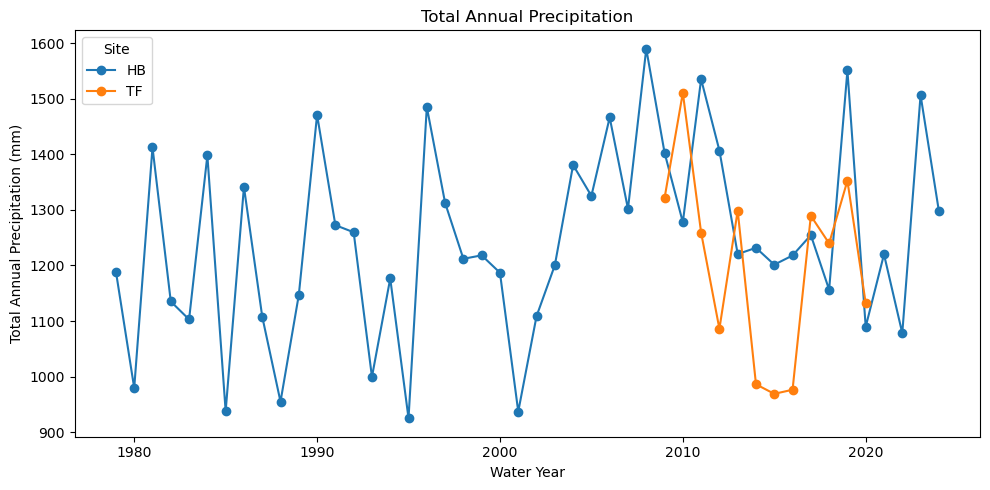

HB: slope = 0.027 events/year, r = 0.24, p = 0.095
TF: slope = -0.110 events/year, r = -0.24, p = 0.435


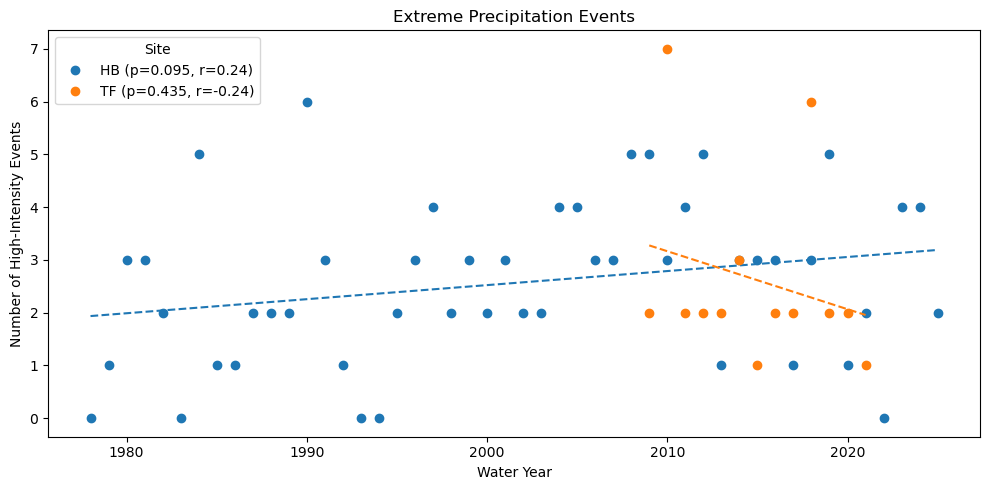

In [8]:
#%%Total Annual Precipitation

annual_total = (
    df_precip_clean.groupby(['site', 'WaterYear'])
    .agg(total_precip_mm=('precip_mm', 'sum'),
         num_events=('precip_mm', 'count'))
    .reset_index()
)

# Remove incomplete years
annual_total = annual_total[annual_total['num_events'] >= 50]

#Plot annual number of extreme events
fig, ax = plt.subplots(figsize=(10,5))

for site in annual_total['site'].unique():
    site_data = annual_total[annual_total['site'] == site]
    ax.plot(site_data['WaterYear'], site_data['total_precip_mm'], 'o-', label=site)

ax.set_xlabel('Water Year')
ax.set_ylabel('Total Annual Precipitation (mm)')
ax.set_title('Total Annual Precipitation')
ax.legend(title='Site')
plt.tight_layout()
plt.show()

#%%High-Intensity Precipitation Events

thresholds = df_precip_clean.groupby('site')['precip_mm'].quantile(0.95)

df_precip_clean['high_event'] = df_precip_clean.apply(
    lambda r: r['precip_mm'] >= thresholds[r['site']], axis=1)

high_event_counts = (
    df_precip_clean.groupby(['site', 'WaterYear'])
    .agg(n_high_events=('high_event', 'sum'),
         n_events=('precip_mm', 'count'))
    .reset_index())

#Plot with regression statistics
fig, ax = plt.subplots(figsize=(10,5))

for site in high_event_counts['site'].unique():
    site_data = high_event_counts[high_event_counts['site'] == site].dropna(subset=['n_high_events'])
    
    # Perform linear regression
    slope, intercept, r, p, stderr = linregress(site_data['WaterYear'], site_data['n_high_events'])
    
    # Compute regression line
    x_vals = np.array(site_data['WaterYear'])
    y_fit = intercept + slope * x_vals
    
    # Plot observed data and trend line
    ax.plot(site_data['WaterYear'], site_data['n_high_events'], 'o', label=f'{site} (p={p:.3f}, r={r:.2f})')
    ax.plot(x_vals, y_fit, '--', color=ax.lines[-1].get_color())
    
    # Print results in console
    print(f"{site}: slope = {slope:.3f} events/year, r = {r:.2f}, p = {p:.3f}")

# Axis labels and title
ax.set_xlabel('Water Year')
ax.set_ylabel('Number of High-Intensity Events')
ax.set_title('Extreme Precipitation Events')
ax.legend(title='Site')

plt.tight_layout()
plt.show()

## Chemistry and Precipitaion Data

### Bar graph or line graph of nitrogen deposition over time
Might end up being multiple figures since there are different species of nitrogen (e.g. TDN, NH4, NO3). I will also be calculating fluxes and ploting them along with the raw concentrations

In [9]:
# Calculate nitrogen flux
# Convert mL of precipitation to L/m^2, then multiply by concentration (mg/L)
# Plot time series of nitrogen fluxes

### Determine relationship between precipitation and nitrogen deposition
Test whether high-precipitation events drive higher nitrogen deposition

In [10]:
# Calculate correlation between weekly precipitation and nitrogen flux
# Plot scatterplots with regression lines for both sites

## DISCUSSION